# Assignment 5: Scene Recognition with Bag of Words
## CPSC 425 - Computer Vision
### Leo Foord-Kelcey - 83974592

**Due date: Nov 29**

### Boilerplate

In [1]:
import numpy as np
from util import load, build_vocabulary, get_bags_of_sifts
from classifiers import nearest_neighbor_classify, svm_classify

### Submission Notes

Method Implementation:
- Bag of Features -> Build Vocabulary
- Bag of Features -> Create Bags of SIFTs
- kNN ... -> Implement Classifier
- Linear SVM ... -> Implement Classifier
  - Please ignore the "failed to converge" error that comes with sklearn's RandomizedSearchCV. This is not a problematic error.

Histograms:
- Bag of Features -> Discussion -> Histograms

Confusion Matrix:
- kNN ... -> Evaluate Results
- Linear SVM ... -> Evaluate Results

Discussion:
- Bag of Features -> Discussion -> Observations
- kNN ... -> Evaluate Results
- Linear SVM ... -> Evaluate Results

Final Results:
- Results Summary

### Setup

In [2]:
print('Getting paths and labels for all train and test data\n')
train_image_paths, train_labels = load("sift/train")
test_image_paths, test_labels = load("sift/test")

Getting paths and labels for all train and test data



## 4. Bag of Features (10 points)

### Set Vocabulary Size

In [3]:
vocab_size = 50

### Build Vocabulary

In [4]:
import numpy as np
import os
import glob
from sklearn.cluster import KMeans
import random
from yellowbrick.cluster import KElbowVisualizer

In [5]:
def build_vocabulary(image_paths, vocab_size):
    """ Sample SIFT descriptors, cluster them using k-means, and return the fitted k-means model.
    NOTE: We don't necessarily need to use the entire training dataset. You can use the function
    sample_images() to sample a subset of images, and pass them into this function.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    vocab_size: the number of clusters desired.
    
    Returns
    -------
    kmeans: the fitted k-means clustering model.
    """
    n_image = len(image_paths)

    # Since want to sample tens of thousands of SIFT descriptors from different images, we
    # calculate the number of SIFT descriptors we need to sample from each image.
    n_each = int(np.ceil(10000 / n_image))

    # Initialize an array of features, which will store the sampled descriptors
    # keypoints = np.zeros((n_image * n_each, 2))
    descriptors = np.zeros((n_image * n_each, 128))

    for i, path in enumerate(image_paths):
       
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)
        sift_keypoints = features[:, :2]
        sift_descriptors = features[:, 2:]

        # TODO: Randomly sample n_each descriptors from sift_descriptor and store them into descriptors
        
        randoms = random.sample(range(0, sift_descriptors.shape[0]), n_each)
        
        for j in range(n_each):
            
            n = randoms[j]
            descriptors[i] = sift_descriptors[n]
            
    # TODO: pefrom k-means clustering to cluster sampled sift descriptors into vocab_size regions.
    # You can use KMeans from sci-kit learn.
    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    
    kmeans = KMeans(n_clusters=vocab_size)
    kmeans.fit(descriptors)
    
    return kmeans

In [6]:
kmeans = build_vocabulary(train_image_paths, vocab_size=vocab_size)

### Create Bags of SIFTs

In [7]:
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt

In [8]:
def get_bags_of_sifts(image_paths, kmeans):
    """ Represent each image as bags of SIFT features histogram.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    kmeans: k-means clustering model with vocab_size centroids.

    Returns
    -------
    image_feats: an (n_image, vocab_size) matrix, where each row is a histogram.
    """
    n_image = len(image_paths)
    vocab_size = kmeans.cluster_centers_.shape[0]

    image_feats = np.zeros((n_image, vocab_size))

    for i, path in enumerate(image_paths):
        
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)

        # TODO: Assign each feature to the closest cluster center
        # Again, each feature consists of the (x, y) location and the 128-dimensional sift descriptor
        # You can access the sift descriptors part by features[:, 2:]
        
        X = features[:, 2:]
        hist = kmeans.predict(X)
        
        # TODO: Build a histogram normalized by the number of descriptors
        
        image_feats[i], bins, p = plt.hist(hist, bins=vocab_size, density=True)
        plt.close()
        
    return image_feats

In [9]:
train_image_feats = get_bags_of_sifts(train_image_paths, kmeans)
np.savetxt('train_image_feats.txt', train_image_feats)

test_image_feats = get_bags_of_sifts(test_image_paths, kmeans)
np.savetxt('test_image_feats.txt', test_image_feats)

In [10]:
# train_image_feats = np.loadtxt('train_image_feats.txt')
# test_image_feats = np.loadtxt('test_image_feats.txt')

### Discussion

#### Histograms

In [11]:
label_names = [
        'Bedroom', 
        'Coast', 
        'Forest', 
        'Highway', 
        'Industrial', 
        'InsideCity', 
        'Kitchen', 
        'LivingRoom', 
        'Mountain', 
        'Office', 
        'OpenCountry', 
        'Store', 
        'Street',
        'Suburb',
        'TallBuilding'
]

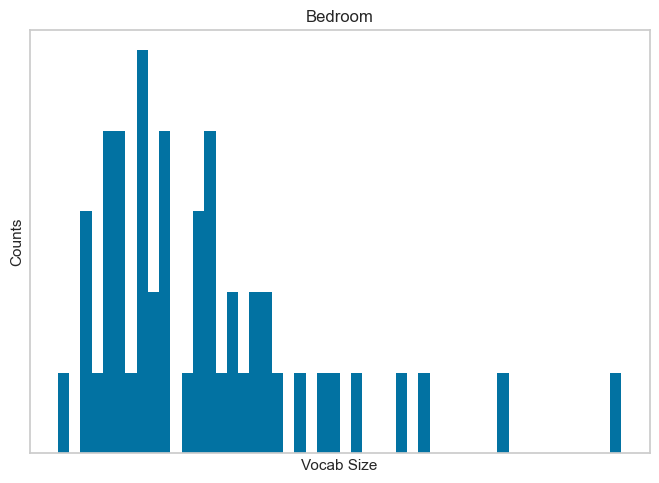

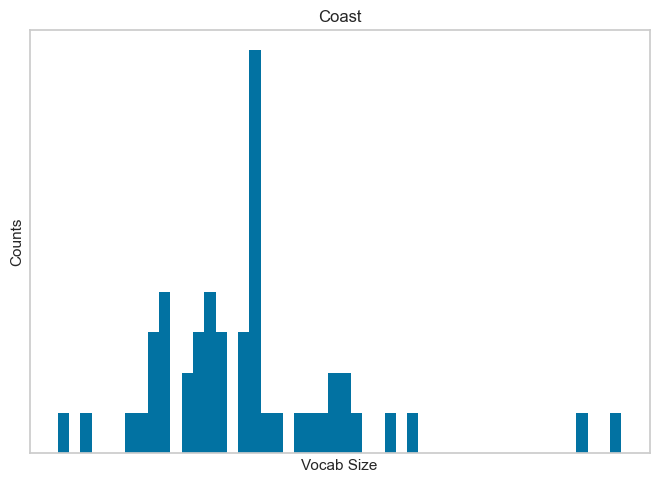

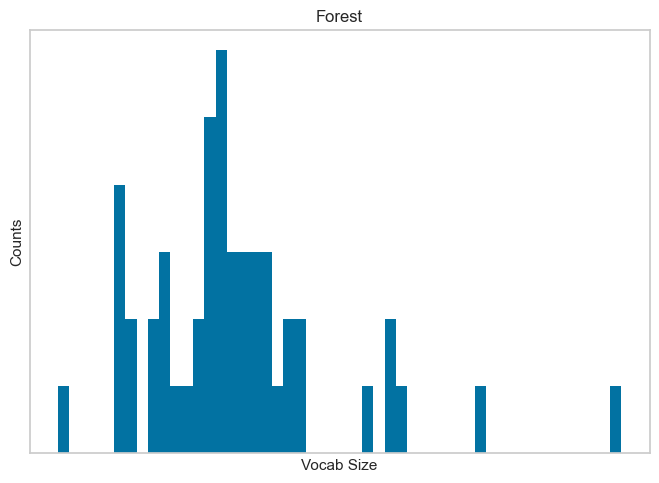

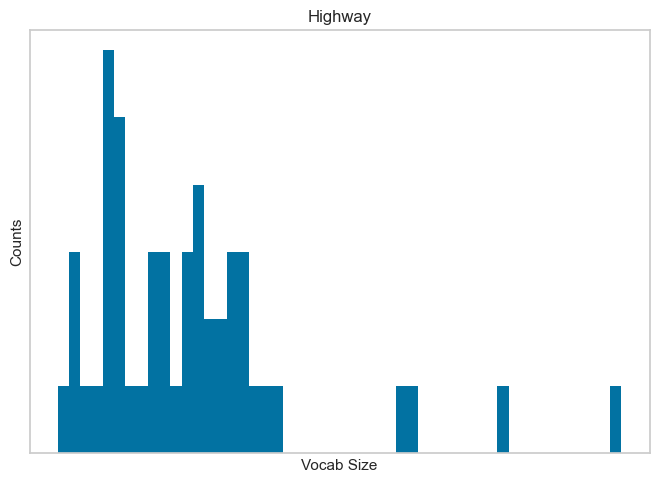

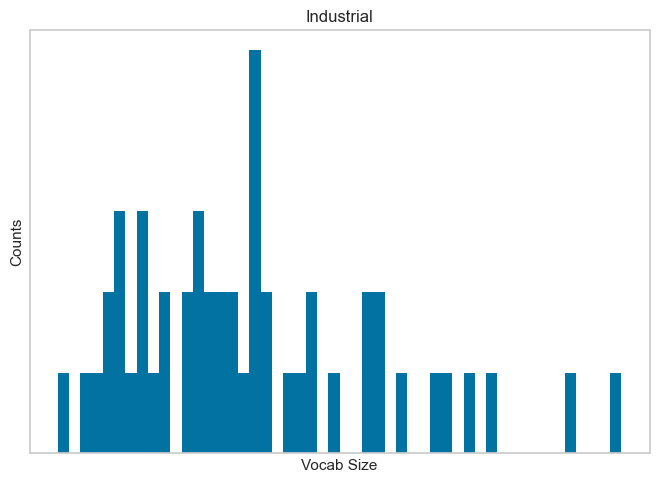

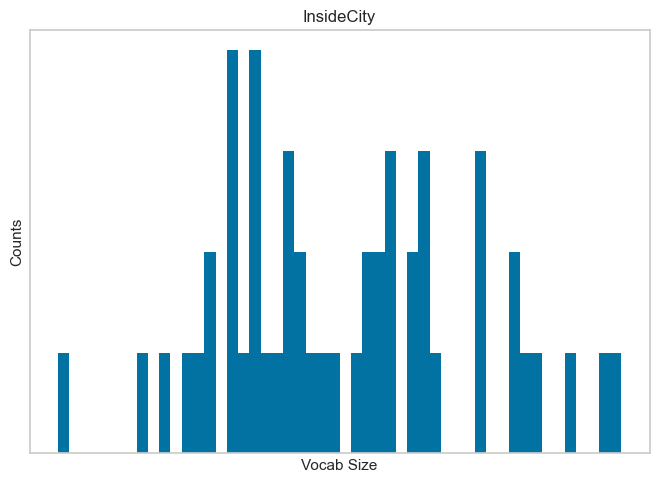

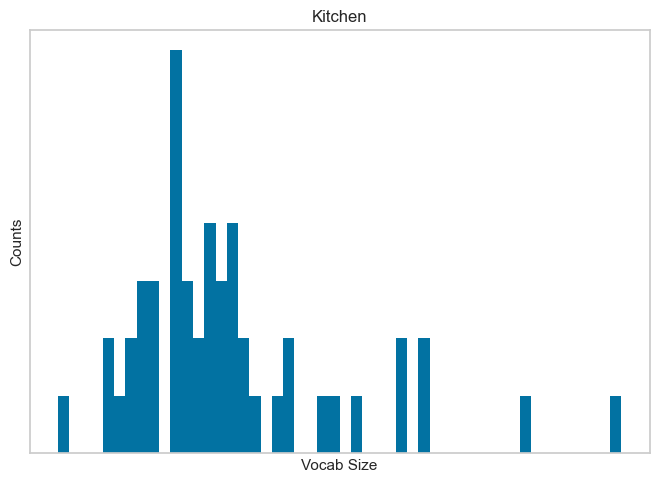

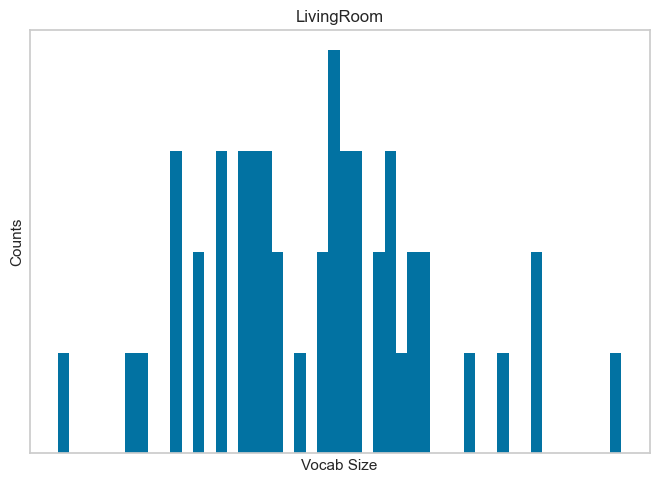

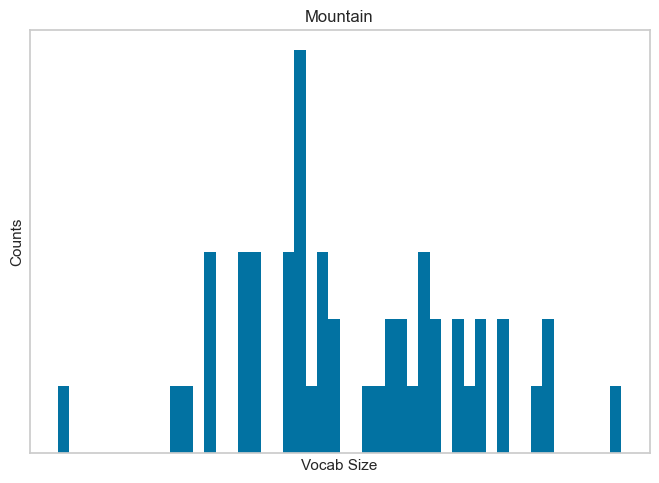

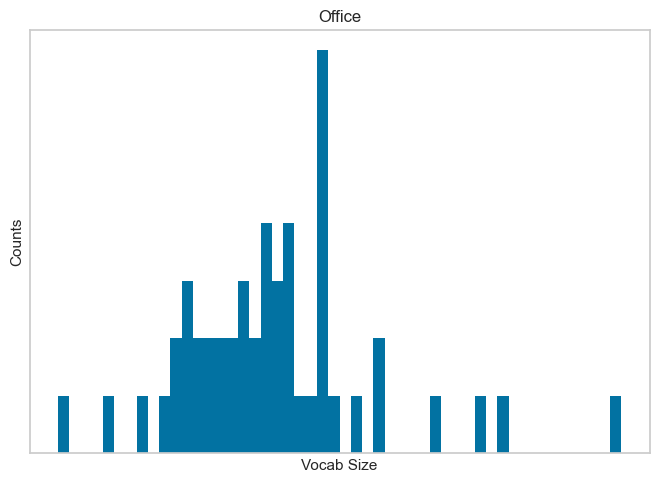

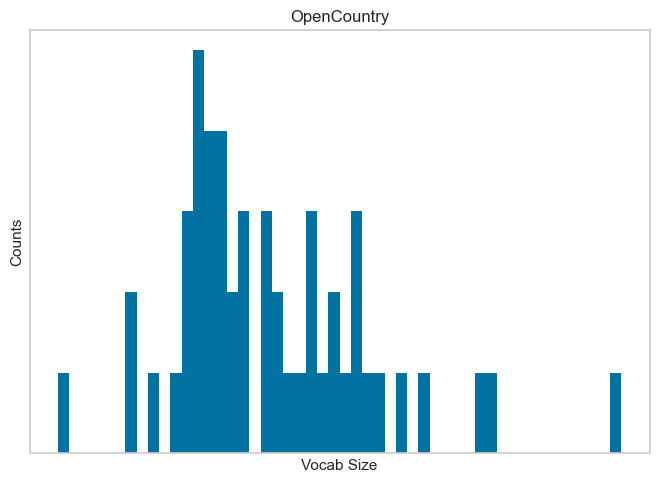

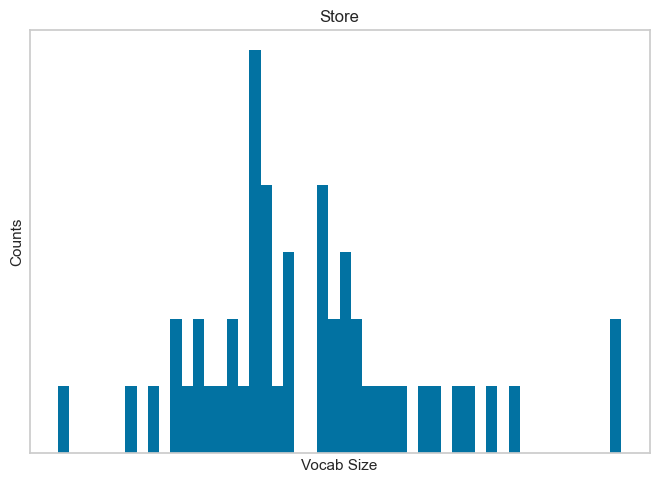

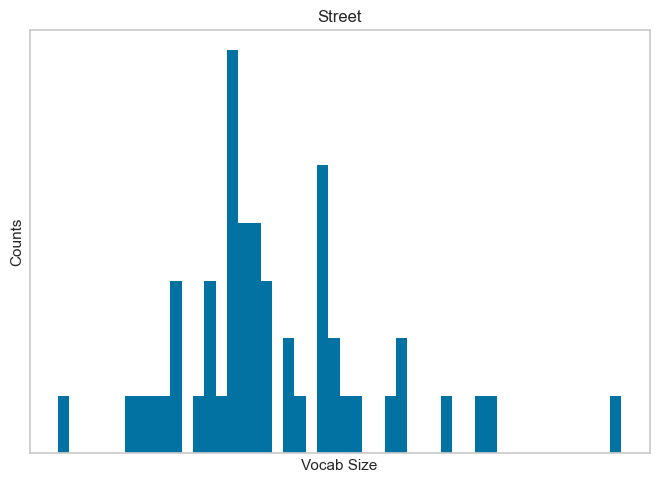

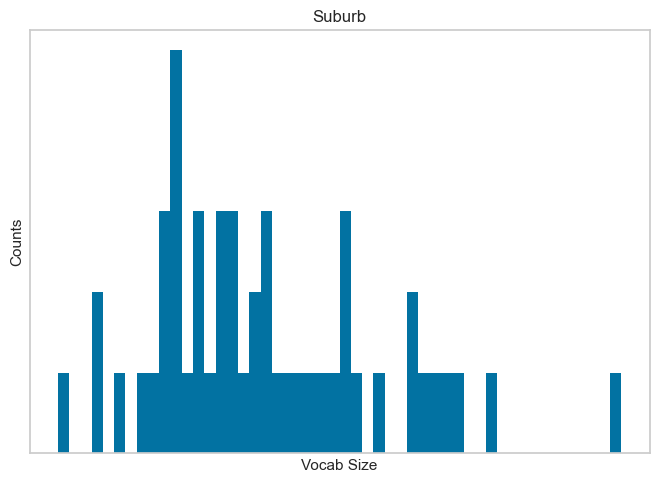

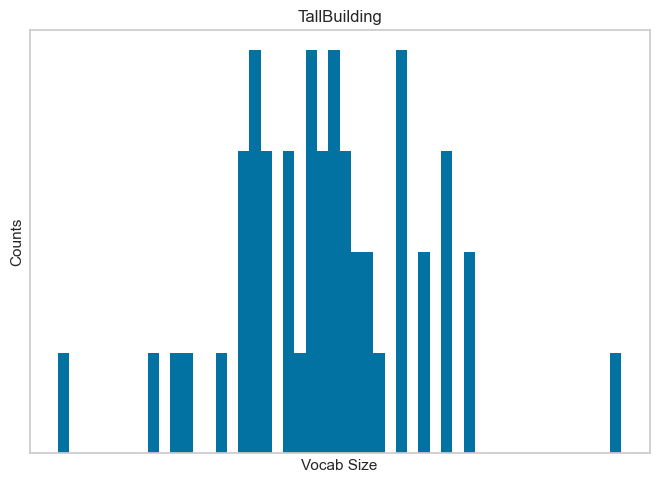

In [12]:
# rearrange train_image_feats to be grouped with category
# histograms[{category 1-15}, {100}, {vocab size}]

histograms = np.zeros((15, 100, vocab_size))

for i in range(15):

    pos = np.where(train_labels == i)
    
    for j in range(len(pos[0])):
        
        index = pos[0][j]
        histograms[i][j] = train_image_feats[index]
        
        
# show average normalized histograms for each category 
for i in range(15):
    
    hist = histograms[i]
    x = np.average(hist, axis=0)
    plt.hist(x, bins=x.shape[0], density=True)
    plt.ylabel('Counts')
    plt.yticks([])
    plt.xlabel('Vocab Size')
    plt.xticks([])
    plt.title(label_names[i])
    plt.show()

#### Observations

It appears that most of the histograms having fairly unique distributions. Some have a similar shape but are shifted, some are skewed similarly but have distinct variance. These aforementioned similarities and differences are typically reflective of how a human would interpret the category names. <br>

I would say that the histograms for `Store` and `Street` would be hardest to distinguish, as they both have are both skewed to the right with a similar median. Similarly, `Coast` and `Forest` would prove somewhat confusing with their histogram distributions. <br>

## 5. kNN Classifier (5 points)

### Implement Classifier 

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV

In [14]:
'''This function will predict the category for every test image by finding
the training image with most similar features. Instead of 1 nearest
neighbor, you can vote based on k nearest neighbors which will increase
performance (although you need to pick a reasonable value for k). '''

def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):

    '''
    Parameters
        ----------
        train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
        train_labels: is an N x l cell array, where each entry is a string 
        			  indicating the ground truth one-hot vector for each training image.
    	test_image_feats: is an M x d matrix, where d is the dimensionality of the
    					  feature representation. You can assume M = N unless you've modified the starter code.
        
    Returns
        -------
    	is an M x l cell array, where each row is a one-hot vector 
        indicating the predicted category for each test image.

    Usefull funtion:
    	
    	# You can use knn from sci-kit learn.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    '''
    
    X_train = train_image_feats
    y_train = train_labels
    X_test = test_image_feats
    
    knn = KNeighborsClassifier()

    param_grid = {
        "n_neighbors": np.arange(1, 40, 1)
    }

    random_search = RandomizedSearchCV(
        knn, param_distributions=param_grid, n_jobs=-1, n_iter=30, cv=5
    )
    
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_['n_neighbors']
    best_score = random_search.best_score_
    
    print(f'Best n_neighbors is {best_params} with a cross-validation score of {best_score:.2f}\n')
    
    best_knn = KNeighborsClassifier(n_neighbors=best_params)
    best_knn.fit(X_train, y_train)
    predicted_labels = best_knn.predict(X_test)
    
    return predicted_labels

In [15]:
print('Using nearest neighbor classifier to predict test set categories\n')
pred_labels_knn = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)

Using nearest neighbor classifier to predict test set categories

Best n_neighbors is 15 with a cross-validation score of 0.36



### Evaluate Results

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [17]:
def decode(y_pred_encoded, y_test_encoded):

    y_test = [0] * len(y_test_encoded)

    for i in range(15):
        pos = np.where(y_test_encoded == i)
        for j in range(len(pos[0])):
            index = pos[0][j]
            y_test[index] = label_names[i]
    
    y_pred = [0] * len(y_pred_encoded)

    for i in range(15):
        pos = np.where(y_pred_encoded == i)
        for j in range(len(pos[0])):
            index = pos[0][j]
            y_pred[index] = label_names[i]
            
    return y_pred, y_test

In [18]:
def evaluation(y_pred_encoded):
    
    print('---Evaluation on Test Set---\n')
    
    y_pred, y_test = decode(y_pred_encoded, test_labels)

    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}\n')

    cm = confusion_matrix(y_test, y_pred)
    
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_title('Confusion Matrix') 
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.xaxis.set_ticklabels(label_names) 
    ax.yaxis.set_ticklabels(label_names)
    ax.xaxis.set_tick_params(labelsize=5)
    ax.yaxis.set_tick_params(labelsize=4)

    print(classification_report(y_test, y_pred))

Prior to evaluating on the test set, I conducted hyperparameter optimization on hyperparameter `n_neighbors` (or k). <br>

By using sklearn's RandomSearchCV, I carried out 5 fold cross validation (cv) on the train set randomely selecting a value for `n_neighbors` from the set `param_grid`. <br>

From this I found that `n_neighbors = 15` produced the best cross validation score, and thus I chose to use this when predicting against the test set. <br>

Experimenting with different values of `n_neighbors` I found that a `larger` value tended to increase the cv error, and a `smaller` value tended to overfit on the training set and increase model complexity. Thus it makes sense that, through optimizing, I found an value at an appropriate middle ground. 

---Evaluation on Test Set---

Accuracy: 0.38

              precision    recall  f1-score   support

     Bedroom       0.71      0.90      0.79        30
       Coast       0.16      0.20      0.18        30
      Forest       0.44      0.60      0.51        30
     Highway       0.37      0.33      0.35        30
  Industrial       0.33      0.07      0.11        30
  InsideCity       0.38      0.47      0.42        30
     Kitchen       0.25      0.07      0.11        30
  LivingRoom       0.12      0.10      0.11        30
    Mountain       0.22      0.30      0.25        30
      Office       0.24      0.20      0.22        30
 OpenCountry       0.40      0.90      0.56        30
       Store       0.52      0.47      0.49        30
      Street       0.42      0.17      0.24        30
      Suburb       0.73      0.27      0.39        30
TallBuilding       0.43      0.70      0.53        30

    accuracy                           0.38       450
   macro avg       0.38      0.38 

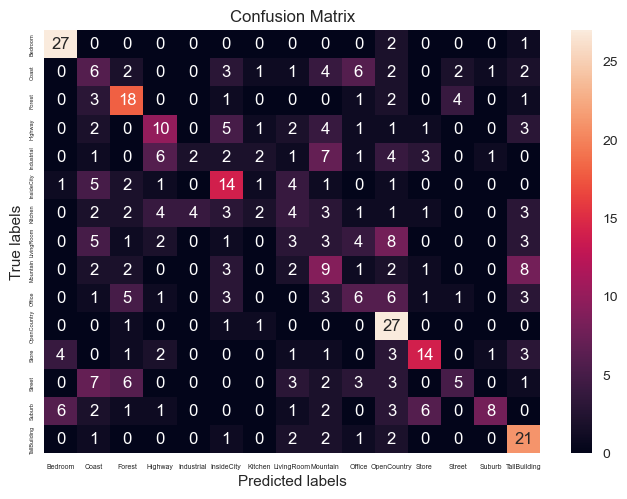

In [19]:
evaluation(pred_labels_knn)

## 5. Linear SVM (One vs. All) Classifier (10 points)

### Implement Classifier 

In [20]:
from sklearn.svm import LinearSVC

In [21]:
'''This function will train a linear SVM for every category (i.e. one vs all)
and then use the learned linear classifiers to predict the category of
very test image. Every test feature will be evaluated with all 15 SVMs
and the most confident SVM will "win". Confidence, or distance from the
margin, is W*X + B where '*' is the inner product or dot product and W and
B are the learned hyperplane parameters. '''

def svm_classify(train_image_feats, train_labels, test_image_feats):

    '''
    Parameters
        ----------
        train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
        train_labels: is an N x l cell array, where each entry is a string 
        			  indicating the ground truth one-hot vector for each training image.
    	test_image_feats: is an M x d matrix, where d is the dimensionality of the
    					  feature representation. You can assume M = N unless you've modified the starter code.
        
    Returns
        -------
    	is an M x l cell array, where each row is a one-hot vector 
        indicating the predicted category for each test image.

    Usefull funtion:
    	
    	# You can use svm from sci-kit learn.
        # Reference: https://scikit-learn.org/stable/modules/svm.html

    '''
    
    X_train = train_image_feats
    y_train = train_labels
    X_test = test_image_feats
    
    clf = LinearSVC()

    param_grid = {
        "C": np.arange(1, 40, 1)
    }

    random_search = RandomizedSearchCV(
        clf, param_distributions=param_grid, n_jobs=-1, n_iter=30, cv=5
    )
    
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_['C']
    best_score = random_search.best_score_
    
    print('Using Linear SVM (One vs. All) to predict test set categories\n')
    
    print(f'Best C is {best_params} with a cross-validation score of {best_score:.2f}\n')
    
    results_df = pd.DataFrame(random_search.cv_results_)[
        [
            "mean_test_score",
            "param_C",
            "rank_test_score",
        ]
    ].set_index("rank_test_score").sort_index().T

    # print(results_df)
    
    best_clf = LinearSVC(C=best_params)
    best_clf.fit(X_train, y_train)
    predicted_labels = best_clf.predict(X_test)
    
    return predicted_labels

In [22]:
pred_labels_svm = svm_classify(train_image_feats, train_labels, test_image_feats)

/Users/leofk/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/leofk/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/leofk/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/leofk/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/leofk/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/leo

Using Linear SVM (One vs. All) to predict test set categories

Best C is 17 with a cross-validation score of 0.43



### Evaluate Results 

Prior to evaluating on the test set, I conducted hyperparameter optimization on hyperparameter `C`. <br>

By using sklearn's RandomSearchCV, I carried out 5 fold cross validation (cv) on the train set randomely selecting a value for `C` from the set `param_grid`. <br>

From this I found that `C = 17` produced the best cross validation score, and thus I chose to use this when predicting against the test set. <br>

Experimenting with different values of `C` I found that a `smaller` value (0.001 to 1) tended to increase the cv error, and a `larger` (100 to 100000) value tended to overfit on the training set and increase model complexity. Thus it makes sense that, through optimizing, I found an value at an appropriate middle ground. 

---Evaluation on Test Set---

Accuracy: 0.45

              precision    recall  f1-score   support

     Bedroom       0.74      0.93      0.82        30
       Coast       0.32      0.30      0.31        30
      Forest       0.50      0.67      0.57        30
     Highway       0.27      0.30      0.29        30
  Industrial       0.42      0.37      0.39        30
  InsideCity       0.47      0.50      0.48        30
     Kitchen       0.34      0.33      0.34        30
  LivingRoom       0.22      0.07      0.10        30
    Mountain       0.41      0.40      0.41        30
      Office       0.37      0.23      0.29        30
 OpenCountry       0.58      0.87      0.69        30
       Store       0.44      0.53      0.48        30
      Street       0.29      0.20      0.24        30
      Suburb       0.35      0.27      0.30        30
TallBuilding       0.52      0.73      0.61        30

    accuracy                           0.45       450
   macro avg       0.42      0.45 

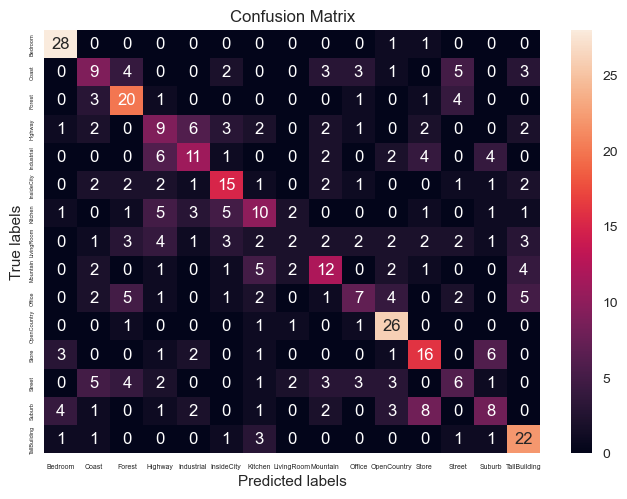

In [23]:
evaluation(pred_labels_svm)

## 6. SVC (One vs. One) Classifier (extra)

### Implement Classifier 

In [24]:
from sklearn.svm import SVC

In [25]:
def svc_classify(train_image_feats, train_labels, test_image_feats):

    '''
    Parameters
        ----------
        train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
        train_labels: is an N x l cell array, where each entry is a string 
        			  indicating the ground truth one-hot vector for each training image.
    	test_image_feats: is an M x d matrix, where d is the dimensionality of the
    					  feature representation. You can assume M = N unless you've modified the starter code.
        
    Returns
        -------
    	is an M x l cell array, where each row is a one-hot vector 
        indicating the predicted category for each test image.
    '''
    
    X_train = train_image_feats
    y_train = train_labels
    X_test = test_image_feats
    
    svc = SVC()

    param_grid = {
        "C": np.arange(1, 40, 1),
        "gamma": np.arange(1, 40, 1)
    }

    random_search = RandomizedSearchCV(
        svc, param_distributions=param_grid, n_jobs=-1, n_iter=50, cv=5
    )
    
    random_search.fit(X_train, y_train)

    best_c = random_search.best_params_['C']
    best_gamma = random_search.best_params_['gamma']
    best_score = random_search.best_score_
    
    print('Using SVC (One vs. One) classifier to predict test set categories\n')
    
    print(f'Best C is {best_c} with best gamma is {best_gamma} with a cross-validation score of {best_score:.2f}\n')
    
    results_df = pd.DataFrame(random_search.cv_results_)[
        [
            "mean_test_score",
            "param_C",
            "param_gamma",
            "rank_test_score",
        ]
    ].set_index("rank_test_score").sort_index().T

    # print(results_df)
    
    best_clf = SVC(C=best_c, gamma=best_gamma)
    best_clf.fit(X_train, y_train)
    predicted_labels = best_clf.predict(X_test)
    
    return predicted_labels

In [26]:
pred_labels_svc = svc_classify(train_image_feats, train_labels, test_image_feats)

Using SVC (One vs. One) classifier to predict test set categories

Best C is 7 with best gamma is 5 with a cross-validation score of 0.47



### Evaluate Results

---Evaluation on Test Set---

Accuracy: 0.48

              precision    recall  f1-score   support

     Bedroom       0.81      0.87      0.84        30
       Coast       0.32      0.33      0.33        30
      Forest       0.46      0.57      0.51        30
     Highway       0.35      0.40      0.38        30
  Industrial       0.50      0.30      0.37        30
  InsideCity       0.52      0.50      0.51        30
     Kitchen       0.53      0.33      0.41        30
  LivingRoom       0.20      0.23      0.22        30
    Mountain       0.43      0.53      0.48        30
      Office       0.36      0.33      0.34        30
 OpenCountry       0.65      0.80      0.72        30
       Store       0.55      0.60      0.57        30
      Street       0.33      0.23      0.27        30
      Suburb       0.65      0.43      0.52        30
TallBuilding       0.54      0.70      0.61        30

    accuracy                           0.48       450
   macro avg       0.48      0.48 

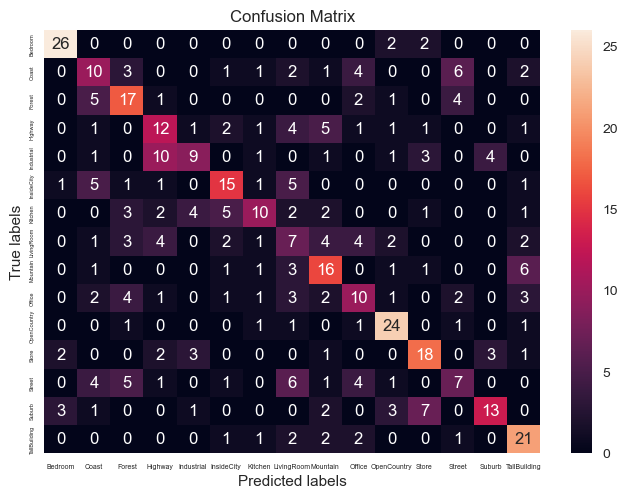

In [27]:
evaluation(pred_labels_svc)

## 7. Results Summary

| Classfier                  | Accuracy | Hyperparameter(s) |
| -----------                | -------- | -------           |
| kNN                        | 0.38     | k = 15              |
| Linear SVM (One vs. All)   | 0.45     | C = 17              |
| SVC (One vs. One)          | 0.47     | C = 7 , gamma = 5  |

Using a vocabulary size of 50 we found that using a linear SVM classifier with a one vs. one strategy performed the best. I also tested my classifiers on a larger vocab size ~200, but I was finding better performance for around 50.